import matplotlib.pyplot as plt
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
# Imports

In [1]:
import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import warnings
from surprise import SVD,NormalPredictor
from surprise.model_selection import train_test_split
from surprise.dataset import Dataset
from surprise import Reader
from surprise import AlgoBase
import random
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms.knns import KNNBasic

from surprise.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

# Package Installs

In [2]:
# !pip install -U scikit-surprise==1.1.0

# Functions

In [3]:
class RandomRating(AlgoBase):
    def __init__(self, p = .5):
        self.p = p
        AlgoBase.__init__(self)
        
    def estimate(self,u,i):
        return np.random.binomial(n = 5,p = self.p,size = 1)[0]
    
    

In [109]:
np.random.seed(0)

def get_data():
    movies = pd.read_csv('ml-latest-small/movies.csv')
    links = pd.read_csv('ml-latest-small/links.csv')
    ratings = pd.read_csv('ml-latest-small/ratings.csv')
    tags = pd.read_csv('ml-latest-small/tags.csv')
    return movies,links,ratings,tags

def clean_data(movies,links,ratings):
    ratings.drop('timestamp',axis = 1, inplace = True)
    
    
    df1 = pd.merge(movies,links,on ='movieId')
    
    df = pd.merge(df1,ratings,on = 'movieId',how = 'inner')
    df['release year'] = df['title'].str[-6:]
    df['title'] = [x[:-6] for x in df['title']]
    df['release year'] = df['release year'].str.extract(r'\((.*)\)')
    df['release year'] = df['release year'].fillna(0).astype(int)
    df['genres'] = df['genres'].str.split('|').astype(str)  
    df.drop(['imdbId','tmdbId'],axis = 1,inplace = True)
#     df.drop('timestamp',axis = 1,inplace = True)
    return df

def ratings_counts(df1):
    df1['ratings count'] = ratings.groupby('movieId')['rating'].count().count()
    df1['average rating'] = ratings.groupby('movieId')['rating'].mean()
#     df1.drop('rating',axis = 1,inplace = True)
    df1.drop_duplicates(subset = 'title',keep = 'last',inplace = True)
    return df1


def predict_evaluate(recsys,dataset,name = 'Algorithm'):
    scores = cross_validate(
    recsys, dataset, measures = ['RMSE','MAE'], cv = 4)
    print('Testset Avg MAE: {:.2f} Avg RMSE : {:.2f} [{}]'.format(scores['test_mae'].mean(), scores['test_rmse'].mean(), name))
    
    
def user_interest():
#     movies['title'] = [x[:-6] for x in movies['title']]
    genre_input = input('Give me a genre: ')
    genre_based = df[df.genres.str.contains(genre_input)]
    titles = list(genre_based['title'])
    title = []
    [title.append(x) for x in titles if x not in title]
    user = (df['userId'].values.max() +1)
    
    movies = pd.DataFrame(columns = df.columns)
    for i in range (1,6):
        
        x = random.choice(titles)
        y = float(input('what would you rate the movie ' + x))
        movies2 = df[(df.title.values == x)]
        movies2.drop_duplicates(subset = 'title',keep = 'first',inplace = True)
        movies2['rating'] = y
        movies2['userId'] = user
        movies = movies.append(movies2)
        
        
    
    return movies

# Pull data from Functions and view the data

In [110]:
movies,links,ratings,tags = get_data()
df = clean_data(movies,links,ratings)


In [111]:
# display(movies.head())
# display(links.head())
# display(ratings.head())
# display(tags.head())

In [112]:
new_df = ratings_counts(df)

In [113]:
df.head()

,movieId,title,genres,userId,rating,release year,ratings count,average rating
214,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",610,5.0,1995,9724,4.000000
324,2,Jumanji,"['Adventure', 'Children', 'Fantasy']",608,2.0,1995,9724,4.000000
376,3,Grumpier Old Men,"['Comedy', 'Romance']",608,2.0,1995,9724,3.250000
383,4,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']",600,1.5,1995,9724,3.095238
432,5,Father of the Bride Part II,['Comedy'],604,3.0,1995,9724,2.645455


# Checking graphs of beginning data

what we are going to do is check the movie dataset for any type of "weird" noise or off setting data. First what we will do is check the datasets ratings for any type of rating malfunction and outliers to the data. After that we will check for some of the highest users who have rated the data. and then we will end with looking at the high and low end to the movies ratings.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<BarContainer object of 19 artists>

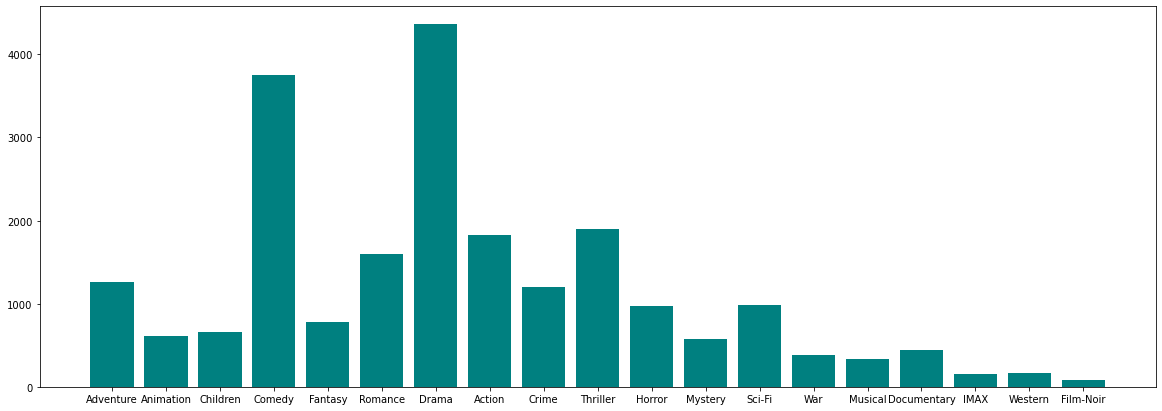

In [114]:
plt.figure(figsize = (20,7))
genlist = movies['genres'].apply(lambda x :str(x).split('|'))
genre_count = {}
for genlist_movie in genlist:
    for genre in genlist_movie:
        if(genre_count.get(genre,False)):
            genre_count[genre] = genre_count[genre] +1
        else:
            genre_count[genre] = 1
genre_count.pop('(no genres listed)')
plt.bar(genre_count.keys(),genre_count.values(),color = 'teal')

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='rating', ylabel='Density'>

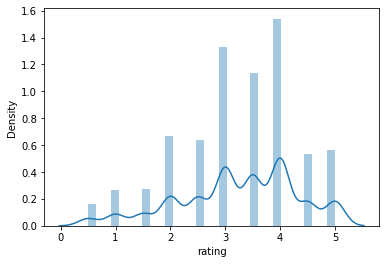

In [115]:
sns.distplot(df['rating'])

<AxesSubplot:xlabel='userId'>

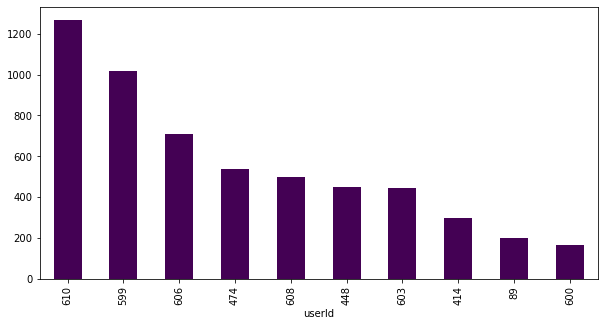

In [116]:
ratings_by_users = df.groupby('userId').agg([np.size,np.mean])
ratings_by_users['rating']['size'].sort_values(ascending = False).head(10).plot(kind ='bar',figsize = (10,5),cmap = 'viridis')

There is no surprise that the high end of the movie ratings only go to 5, so lets take a look at the movies lower end to see what movies are the lowest rated. To make it easier for us we will be looking at the titles of the movies

<AxesSubplot:ylabel='title'>

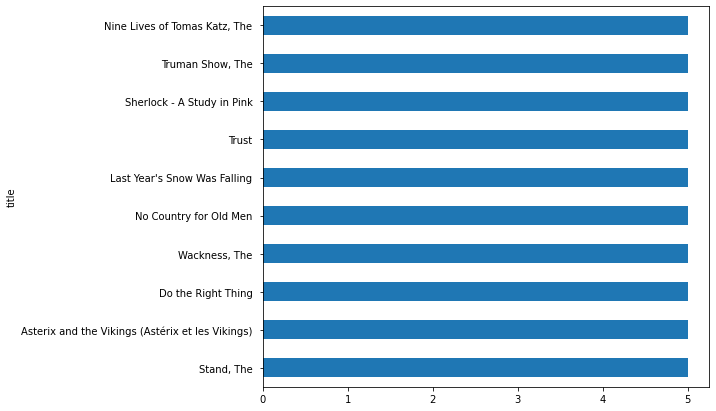

In [117]:
ratings_by_movieId = df.groupby('title').agg([np.mean],np.size)

ratings_by_movieId['rating']['mean'].sort_values(ascending = False).head(10).plot(kind = 'barh',figsize = (8,7))

<AxesSubplot:ylabel='title'>

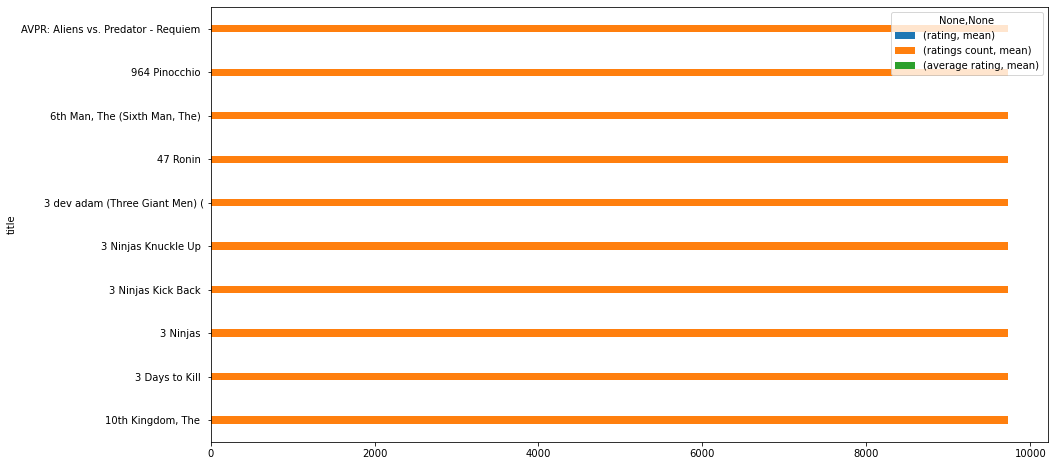

In [118]:
ratings_by_movieId.drop(['release year','movieId','userId'],axis = 1,inplace = True)
low_rated = ratings_by_movieId['rating']['mean'] <1.5
lower = ratings_by_movieId[low_rated]
lower.head(10).plot(kind = 'barh', figsize = (15,8))

In [119]:
lower.head(10)

,rating,ratings count,average rating
,mean,mean,mean
title,,,
"10th Kingdom, The",1.0,9724,NaN
3 Days to Kill,0.5,9724,NaN
3 Ninjas,1.0,9724,NaN
3 Ninjas Kick Back,0.5,9724,NaN
3 Ninjas Knuckle Up,0.5,9724,NaN
3 dev adam (Three Giant Men) (,0.5,9724,NaN
47 Ronin,0.5,9724,NaN
"6th Man, The (Sixth Man, The)",1.0,9724,NaN


# Fixing the cold start problem
The cold start problem is where a new user comes in and we have nothing to recommend to them. This will somewhat solve that problem by asking them to rate a few movies at random and setting it into the dataframe and allowing us to be able to perform some sort of customizing based off of that data. 


In [122]:
user_movies = user_interest()
print("")
print('User movie interest Dataframe')
display(user_movies.head())
df = df.append(user_movies)
print('')
print('Checking dataframe for additions')
df.tail()

Give me a genre:  Action
what would you rate the movie Lost in Space  3
what would you rate the movie Simon Sez  5
what would you rate the movie Death Race 2000  5
what would you rate the movie Jet Li's Fearless (Huo Yuan Jia)  3
what would you rate the movie Wing Commander  2



User movie interest Dataframe


,movieId,title,genres,userId,rating,release year,ratings count,average rating
35916,1831,Lost in Space,"['Action', 'Adventure', 'Sci-Fi']",611,3.0,1998,9724,NaN
49042,2887,Simon Sez,"['Action', 'Comedy']",611,5.0,1999,9724,NaN
75569,7991,Death Race 2000,"['Action', 'Sci-Fi']",611,5.0,1975,9724,NaN
82750,46322,Jet Li's Fearless (Huo Yuan Jia),"['Action', 'Drama']",611,3.0,2006,9724,NaN
44912,2549,Wing Commander,"['Action', 'Sci-Fi']",611,2.0,1999,9724,NaN



Checking dataframe for additions


,movieId,title,genres,userId,rating,release year,ratings count,average rating
35916,1831,Lost in Space,"['Action', 'Adventure', 'Sci-Fi']",611,3.0,1998,9724,NaN
49042,2887,Simon Sez,"['Action', 'Comedy']",611,5.0,1999,9724,NaN
75569,7991,Death Race 2000,"['Action', 'Sci-Fi']",611,5.0,1975,9724,NaN
82750,46322,Jet Li's Fearless (Huo Yuan Jia),"['Action', 'Drama']",611,3.0,2006,9724,NaN
44912,2549,Wing Commander,"['Action', 'Sci-Fi']",611,2.0,1999,9724,NaN


# Setting the vectorizer objects

In [123]:
ratings_pivot = ratings.pivot(index = 'movieId',columns = 'userId', values='rating').reset_index(drop = True)
ratings_pivot.fillna(0, inplace = True)
ratings_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine,correlation

similarity = 1 - pairwise_distances(ratings_pivot.values,metric = 'cosine')
np.fill_diagonal(similarity,0)
rating_matrix = pd.DataFrame(similarity)
rating_matrix

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [125]:
rating_matrix.idxmax(axis = 1).sample(10)

1651    4680
8361    8020
7931    1868
2774    1716
1332    1234
8929    9635
5451     611
4757    1638
4953     805
3705      85
dtype: int64

In [126]:
reader = Reader(rating_scale= (0,5))

dataset = Dataset.load_from_df(ratings,reader)


# Finding the best model and training on that model

In [127]:
trainset,testset = train_test_split(dataset,test_size = .25)

In [128]:
recsys = RandomRating(p=.168)
predict_evaluate(recsys,dataset,'RandomRating')

Testset Avg MAE: 2.71 Avg RMSE : 2.98 [RandomRating]


In [129]:
sim_options = {'name':'cosine', 'user_based': True, 'k':40,'verbose':True}
recsys = KNNBasic(k=20,sim_options = sim_options)
predict_evaluate(recsys,dataset,'KNNBasic')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Testset Avg MAE: 0.75 Avg RMSE : 0.98 [KNNBasic]


In [130]:
sim_options = {'name':'cosine', 'user_based': True, 'k':40,'verbose':True}
recsys = KNNBasic(k=20,sim_options = sim_options)
predict_evaluate(recsys,dataset,'KNNBasic')

# best model

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Testset Avg MAE: 0.75 Avg RMSE : 0.98 [KNNBasic]


Running grid search on a portion of the dataset

In [131]:
# param_grid = {'sim_options':{'name':['cosine','pearson'],
#                             },
#              'k':[5,10,20,40],
#              'verbose':[True]}
# dataset_subset = Dataset.load_from_df(ratings.sample(frac = .25,random_state = 0),reader)
# gscv = GridSearchCV(KNNBasic,param_grid,measures =['rmse','mae'],cv=4,n_jobs =-1)
# gscv.fit(dataset)

# print('Best MAE: ',gscv.best_score['mae'].round(2))
# print('Best RMSE: ',gscv.best_score['rmse'].round(2))
# print('Best Params: ',gscv.best_params['rmse'])

# Testing model on predefined predictions
here we are taking the model and predicting the estimation score of what the model would recommend based off of the given movieId

In [134]:
user = df.userId.values.max()
df['Recommended Score'] = df['movieId'].apply(lambda x: recsys.predict(user,x).est)
recmov = df.sort_values(by=['Recommended Score'],ascending = False)
recmov.drop_duplicates(subset = 'title',keep = 'first',inplace = True)
recmov.head(5)

,movieId,title,genres,userId,rating,release year,ratings count,average rating,Recommended Score
214,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",610,5.0,1995,9724,4.0,3.501778
85908,55267,Dan in Real Life,"['Comedy', 'Drama', 'Romance']",599,2.5,2007,9724,NaN,3.501778
85795,55112,Shanghai Kiss,"['Comedy', 'Drama', 'Romance']",68,4.0,2007,9724,NaN,3.501778
85798,55116,"Hunting Party, The","['Action', 'Adventure', 'Comedy', 'Drama', 'Th...",599,2.5,2007,9724,NaN,3.501778
85817,55118,Eastern Promises,"['Crime', 'Drama', 'Thriller']",610,4.0,2007,9724,NaN,3.501778


In [133]:
# ratings_pivot.head()
# display(ratings['userId'] == 0)
# ratings['userId'].tail()
df.tail()

,movieId,title,genres,userId,rating,release year,ratings count,average rating,Recommended Score
35916,1831,Lost in Space,"['Action', 'Adventure', 'Sci-Fi']",611,3.0,1998,9724,NaN,3.501778
49042,2887,Simon Sez,"['Action', 'Comedy']",611,5.0,1999,9724,NaN,3.501778
75569,7991,Death Race 2000,"['Action', 'Sci-Fi']",611,5.0,1975,9724,NaN,3.501778
82750,46322,Jet Li's Fearless (Huo Yuan Jia),"['Action', 'Drama']",611,3.0,2006,9724,NaN,3.501778
44912,2549,Wing Commander,"['Action', 'Sci-Fi']",611,2.0,1999,9724,NaN,3.501778


# Testing area
using this area to test new production code for project

In [96]:
user

610